In [1]:
!pip install torch torchvision opencv-python

In [2]:
!pip install imutils torchsummary

In [3]:
import numpy as np
import pandas as pd
import os
from os import listdir
import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [5]:
image_dir = "../input/brain-tumor-mri-dataset/"

In [6]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import imutils

In [7]:
class CustomDataset(Dataset):
    def __init__(self, directory, transform=None, add_pixels_value=0):
        self.directory = directory
        self.transform = transform
        self.add_pixels_value = add_pixels_value
        self.image_paths = [os.path.join(directory, img_name) for img_name in os.listdir(directory)]
        self.labels = [self.get_label(os.path.join(directory, img_name)) for img_name in os.listdir(directory)]

    def get_label(self, img_name):
        
        label = 0
        
        if 'glioma' in img_name:
            label = 1
        elif 'meningioma' in img_name:
            label = 2
        elif 'pituitary' in img_name:
            label = 3
        
        return label


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [8]:
IMG_SIZE  = (224, 224)

In [9]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [10]:
train_data = []
for root, dirs, files in os.walk(image_dir+"/Training"):
    for dir_name in dirs:
        train_data += CustomDataset(directory=os.path.join(root, dir_name), transform=test_transform)
        
print(f"Number of images in 'training' dataset: {len(train_data)}")

Number of images in 'training' dataset: 5712


In [11]:
test_data = []
for root, dirs, files in os.walk(image_dir+"/Testing"):
    for dir_name in dirs:
        test_data += CustomDataset(directory=os.path.join(root, dir_name), transform=test_transform)
        
print(f"Number of images in 'Testing' dataset: {len(test_data)}")

Number of images in 'Testing' dataset: 1311


In [12]:
# Load datasets
# yes_dataset = CustomDataset(directory=image_dir+'/yes', transform=test_transform)
# no_dataset = CustomDataset(directory=image_dir+'/no', transform=test_transform)

In [13]:
# Combine and split the datasets
# dataset = yes_dataset + no_dataset
# train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

# train_data, _ = train_test_split(train_data, test_size=0.95, random_state=42)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [14]:
print(f"Number of images in Training: {len(train_data)}")
print(f"Number of images in Testing: {len(test_data)}")

Number of images in Training: 5712
Number of images in Testing: 1311


In [15]:
import math

to_pil = transforms.ToPILImage()

def plot_samples(data_loader, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    # Determine the number of rows and columns for the grid
    cols = int(math.ceil(n ** 0.5))
    rows = int(math.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    axes = axes.flatten()
    
    for i, (img, label) in enumerate(data_loader):
        if i >= n:
            break
        pil_img = to_pil(img)  # Convert tensor to PIL image
        axes[i].imshow(pil_img)
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

In [16]:
# plot_samples(train_data, 30)

In [17]:
classes = 4

In [18]:
# class BrainTumorCNN(nn.Module):
#     def __init__(self):
#         super(BrainTumorCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.fc1 = nn.Linear(64 * 56 * 56, 512)
#         self.dropout1 = nn.Dropout(0.5)  
#         self.fc2 = nn.Linear(512, classes)
    
#     def forward(self, x):
#         x = self.pool(F.relu(self.bn1(self.conv1(x))))
#         x = self.pool(F.relu(self.bn2(self.conv2(x))))
#         x = x.view(-1, 64 * 56 * 56)
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)  
#         x = self.fc2(x)
#         return x

In [19]:
class BrainTumorCNN(nn.Module):
    def __init__(self):
        super(BrainTumorCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, classes)  

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [20]:
# class BrainTumorCNN(nn.Module):
#     def __init__(self):
#         super(BrainTumorCNN, self).__init__()
#         self.model = models.resnet18(pretrained=True)
#         self.model.fc = nn.Linear(self.model.fc.in_features, classes)

#     def forward(self, x):
#         x = self.model(x)
#         return x


In [21]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrainTumorCNN().to(device)

criterion = nn.CrossEntropyLoss()
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [22]:
# Print the model summary
summary(model, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
       BatchNorm2d-5         [-1, 64, 112, 112]             128
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
       BatchNorm2d-8          [-1, 128, 56, 56]             256
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Linear-10                  [-1, 512]      51,380,736
          Dropout-11                  [-1, 512]               0
           Linear-12                    [-1, 4]           2,052
Total params: 51,476,484
Trainable params: 51,476,484
Non-trainable params: 0
-------------------------

In [23]:
def train(model, train_loader, criterion, optimizer, num_epochs=5):
    best_accuracy = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        t_correct = 0
        t_total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            t_total += labels.size(0)
            t_correct += (predicted == labels).sum().item()
                
        epoch_training_accuracy = (100 * t_correct / t_total)
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        epoch_accuracy = (100 * correct / total)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Training Accuracy: {epoch_training_accuracy:.2f}%, Testing Accuracy: {epoch_accuracy:.2f}%')
        
        if epoch_accuracy > best_accuracy:
            best_accuracy = epoch_accuracy
            torch.save({
                'epoch': epoch + 1, 
                'model_state_dict': model.state_dict(), 
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion
            }, './best_weight_cnn.pth')

In [24]:
# Train the model
train(model, train_loader, criterion, optimizer,50)

Epoch 1/50, Loss: 0.8399, Training Accuracy: 72.88%, Testing Accuracy: 80.40%
Epoch 2/50, Loss: 0.4175, Training Accuracy: 83.95%, Testing Accuracy: 86.27%
Epoch 3/50, Loss: 0.3128, Training Accuracy: 88.01%, Testing Accuracy: 85.81%
Epoch 4/50, Loss: 0.2565, Training Accuracy: 90.32%, Testing Accuracy: 90.24%
Epoch 5/50, Loss: 0.2314, Training Accuracy: 91.21%, Testing Accuracy: 91.61%
Epoch 6/50, Loss: 0.1880, Training Accuracy: 93.50%, Testing Accuracy: 92.52%
Epoch 7/50, Loss: 0.1567, Training Accuracy: 94.07%, Testing Accuracy: 92.52%
Epoch 8/50, Loss: 0.1373, Training Accuracy: 94.87%, Testing Accuracy: 89.17%
Epoch 9/50, Loss: 0.1161, Training Accuracy: 95.55%, Testing Accuracy: 95.80%
Epoch 10/50, Loss: 0.1058, Training Accuracy: 96.17%, Testing Accuracy: 95.50%
Epoch 11/50, Loss: 0.0823, Training Accuracy: 96.80%, Testing Accuracy: 96.26%
Epoch 12/50, Loss: 0.0813, Training Accuracy: 97.23%, Testing Accuracy: 96.34%
Epoch 13/50, Loss: 0.0703, Training Accuracy: 97.46%, Testing

In [25]:
model_best = BrainTumorCNN().to(device)

best_model_cp = torch.load('best_weight_cnn.pth')
best_model_epoch = best_model_cp['epoch']
print(f"Best model was saved at {best_model_epoch} epochs\n")

Best model was saved at 42 epochs



In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    total_confusion_matrix = None
    class_labels = [0, 1, 2, 3]  
    class_names = ['No Tumor', 'Glioma', 'Meningioma', 'Pituitary'] 
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            batch_confusion_matrix = confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy(), labels=class_labels)
            if total_confusion_matrix is None:
                total_confusion_matrix = batch_confusion_matrix
            else:
                total_confusion_matrix += batch_confusion_matrix
    
    print(f'Accuracy: {(100 * correct / total):.2f}%, Total: {total}, Correct: {correct}, Wrong: {total - correct}')
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(total_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

Accuracy: 98.09%, Total: 1311, Correct: 1286, Wrong: 25


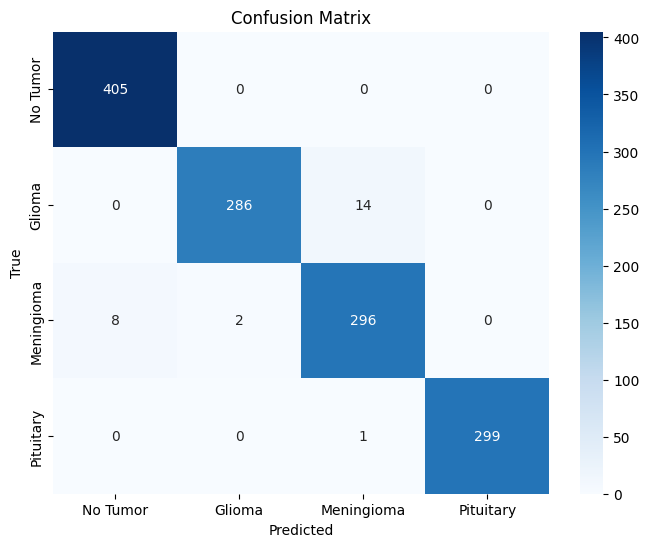

In [28]:
# Evaluate the model
model_best.load_state_dict(best_model_cp['model_state_dict'])

evaluate(model_best, test_loader)